In [81]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import os

In [82]:
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

## Load datasets

In [83]:
dataset_path = '../../dataset/additional_datasets/'
dataset_name = 'Breast_GSE45827'
dataset_norm_suffix = '_norm'
dataset_pca_suffix = '_pca'

xgboost_path = 'saved_models/XGBoost/'
knn_path = 'saved_models/KNN/'
svm_path = 'saved_models/SVM/'

with open('../../preprocessing/class_mapping.pickle', 'rb') as handle:
    class_mapping = pickle.load(handle)

In [84]:
df_norm = pd.read_csv(dataset_path + dataset_name + dataset_norm_suffix + '.csv', index_col=0)
X_norm = df_norm.drop('type', axis=1)
y_norm = df_norm.type

## Load best models for each type

In [85]:
PCA_COMPONENTS = 90

def create_file_name(path, pca_flag, smote_flag):
    file_name = path
    if pca_flag:
        file_name += 'pca_'
    else:
        file_name += 'norm_'
    if smote_flag:
        file_name += 'res_'
    
    file_name += 'model.pickle'
    
    return file_name

In [86]:
XGBOOST_PCA = False
XGBOOST_SMOTE = False

xgboost_model = pickle.load(open(create_file_name(xgboost_path, XGBOOST_PCA, XGBOOST_SMOTE), 'rb'))

In [87]:
SVM_PCA = False
SVM_SMOTE = False

svm_model = pickle.load(open(create_file_name(svm_path, SVM_PCA, SVM_SMOTE), 'rb'))

In [88]:
KNN_PCA = False
KNN_SMOTE = True

knn_model = pickle.load(open(create_file_name(knn_path, KNN_PCA, KNN_SMOTE), 'rb'))

## Test

In [89]:
def test(X, y, model, pca=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if pca:
        pca = PCA(n_components=PCA_COMPONENTS)
        pca.fit(X_train)
        X_train = pca.transform(X_train)
        X_test = pca.transform(X_test)

    preds = model.predict(X_test)
    return model, preds, y_test

In [90]:
xgboost_model, xgboost_pred, xgboost_true = test(X_norm, y_norm, xgboost_model, XGBOOST_PCA)

c:\Users\Branko\miniconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [91]:
svm_model, svm_pred, svm_true = test(X_norm, y_norm, svm_model, SVM_PCA)

In [92]:
knn_model, knn_pred, knn_true = test(X_norm, y_norm, knn_model, KNN_PCA)

## Results

In [93]:
f1_results = {
    'XGBoost': f1_score(xgboost_true, xgboost_pred, average='weighted') * 100,
    'SVM': f1_score(svm_true, svm_pred, average='weighted') * 100,
    'KNN': f1_score(knn_true, knn_pred, average='weighted') * 100,
}
acc_results = {
    'XGBoost': accuracy_score(xgboost_true, xgboost_pred) * 100,
    'SVM': accuracy_score(svm_true, svm_pred) * 100,
    'KNN': accuracy_score(knn_true, knn_pred) * 100
}

### Best model (F1 score)

{'XGBoost': 93.54838709677419, 'SVM': 90.58531601226099, 'KNN': 84.40252031333625}


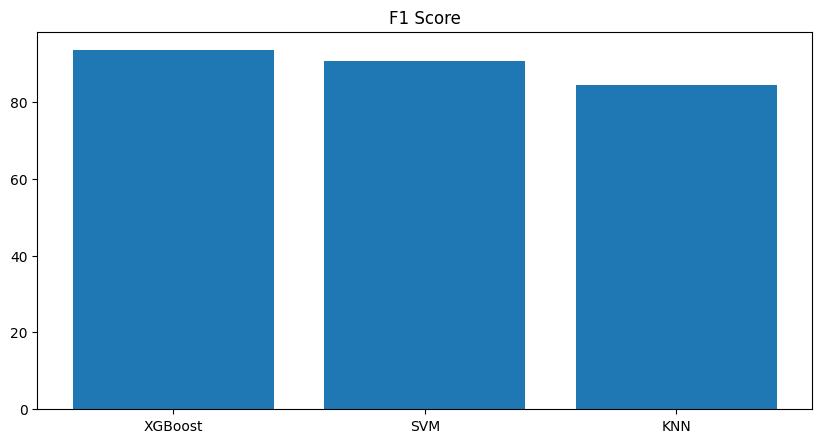

In [94]:
# Sort f1 results by value
f1_results = dict(sorted(f1_results.items(), key=lambda item: item[1], reverse=True))
print(f1_results)

# Plot f1 results
plt.figure(figsize=(10, 5), dpi=100)
plt.title('F1 Score')
plt.bar(f1_results.keys(), f1_results.values())

# Save figure
if not os.path.exists('../../figures/Classification Comparison'):
    os.makedirs('../../figures/Classification Comparison')

plt.savefig('../../figures/Classification Comparison/Classification comparison F1 score.png')

plt.show()

### Best models (Accuracy Score)

{'XGBoost': 93.54838709677419, 'SVM': 90.32258064516128, 'KNN': 83.87096774193549}


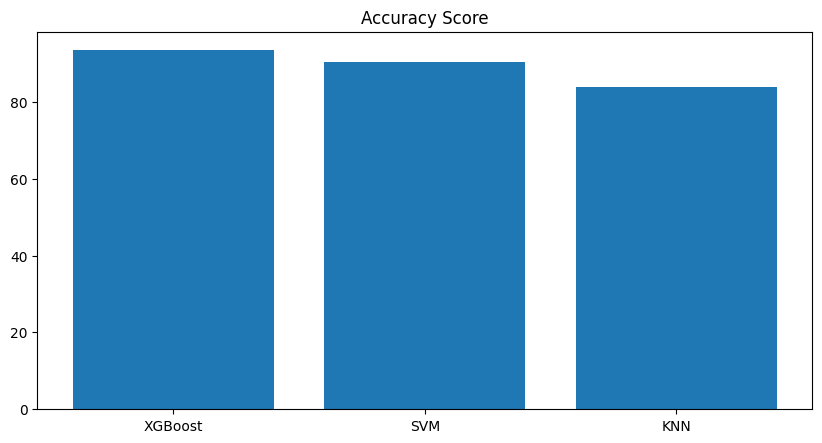

In [95]:
# Sort f1 results by value
acc_results = dict(sorted(acc_results.items(), key=lambda item: item[1], reverse=True))
print(acc_results)

# Plot f1 results
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Accuracy Score')
plt.bar(acc_results.keys(), acc_results.values())
plt.show()

## Ensemble

In [96]:
def ensemble_model(X, y, models=[xgboost_model, knn_model, svm_model], pca_flag=[XGBOOST_PCA, KNN_PCA, SVM_PCA], smote_flag=[XGBOOST_SMOTE, KNN_SMOTE, SVM_SMOTE]):

    preds = []
    for ind in range(len(models)):
        print("Fitting model ", ind)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model = models[ind]
        if pca_flag[ind]:
            pca = PCA(n_components=PCA_COMPONENTS)
            pca.fit(X_train)
            X_train = pca.transform(X_train)
            X_test = pca.transform(X_test)
        if smote_flag[ind]:
            sm = SMOTE(random_state=42)
            X_train, y_train = sm.fit_resample(X_train, y_train)

        print("F1 Score: ", f1_score(y_test, model.predict(X_test), average='weighted') * 100, '%')
        
        preds.append(model.predict(X_test))
    
    preds = np.array(preds)
    print(preds)

    preds = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=preds)

    print("F1 score: ", f1_score(y_test, preds, average='weighted') * 100, '%')

    return y_test, preds

In [97]:
ensemble_true, ensemble_pred = ensemble_model(X_norm, y_norm)

Fitting model  0


c:\Users\Branko\miniconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


F1 Score:  93.54838709677419 %


c:\Users\Branko\miniconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting model  1
F1 Score:  84.40252031333625 %
Fitting model  2
F1 Score:  90.58531601226099 %
[[2 0 2 2 5 0 0 1 1 3 1 0 0 0 0 5 4 5 1 5 0 2 2 5 5 5 4 1 4 0 0]
 [2 0 2 2 5 0 2 1 1 3 1 1 1 0 0 5 4 5 1 4 0 2 1 5 5 4 4 1 4 0 0]
 [2 0 2 2 5 0 2 1 1 3 1 1 1 0 0 5 4 5 1 5 0 2 1 5 5 5 4 1 4 0 0]]
F1 score:  90.58531601226099 %


In [98]:
# Update f1_results with ensemble model
f1_results['Ensemble'] = f1_score(ensemble_true, ensemble_pred, average='weighted') * 100

{'XGBoost': 93.54838709677419, 'SVM': 90.58531601226099, 'Ensemble': 90.58531601226099, 'KNN': 84.40252031333625}


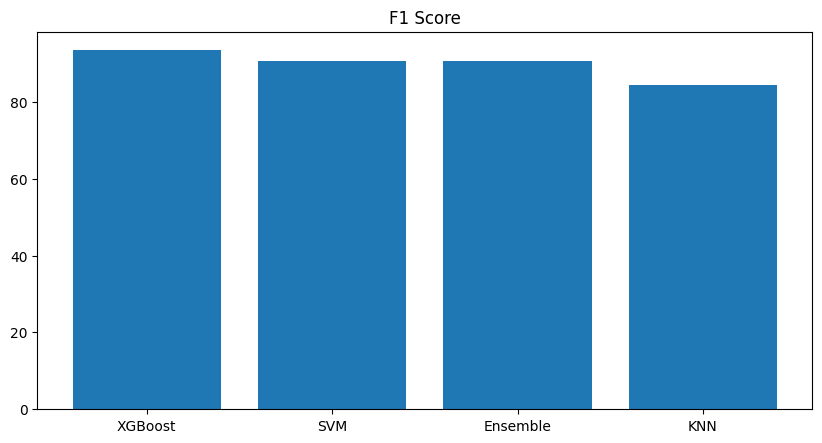

In [99]:
# Sort f1 results by value
f1_results = dict(sorted(f1_results.items(), key=lambda item: item[1], reverse=True))
print(f1_results)

# Plot f1 results
plt.figure(figsize=(10, 5), dpi=100)
plt.title('F1 Score')
plt.bar(f1_results.keys(), f1_results.values())

# Save figure
if not os.path.exists('../../figures/Classification Comparison'):
    os.makedirs('../../figures/Classification Comparison')

plt.savefig('../../figures/Classification Comparison/Ensemble comparison F1 score.png')

plt.show()

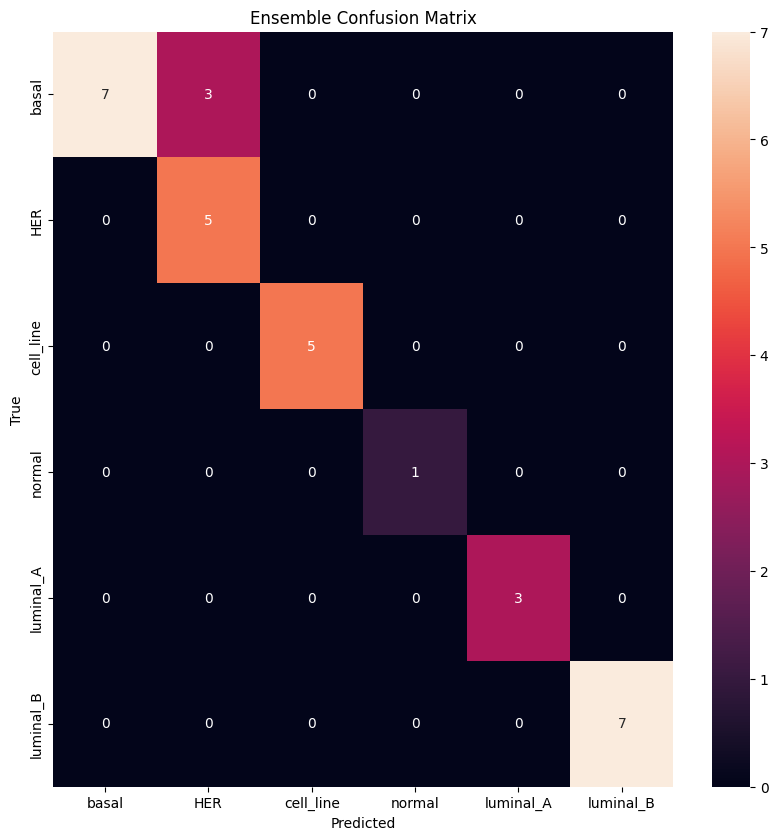

In [100]:
plt.figure(figsize=(10, 10), dpi=100)
plt.title('Ensemble Confusion Matrix')
sns.heatmap(confusion_matrix(ensemble_true, ensemble_pred), xticklabels=class_mapping, yticklabels=class_mapping, annot=True, fmt='g')
plt.ylabel('True')
plt.xlabel('Predicted')

# Save figure
if not os.path.exists('../../figures/Classification Comparison'):
    os.makedirs('../../figures/Classification Comparison')

plt.savefig('../../figures/Classification Comparison/Ensemble confusion matrix.png')

plt.show()

## Conclusion

We can conclude that XGBoost is better at predicting than ensemble method because of it's superiority in prediction